In [2]:
#pip install opencv-python matplotlib


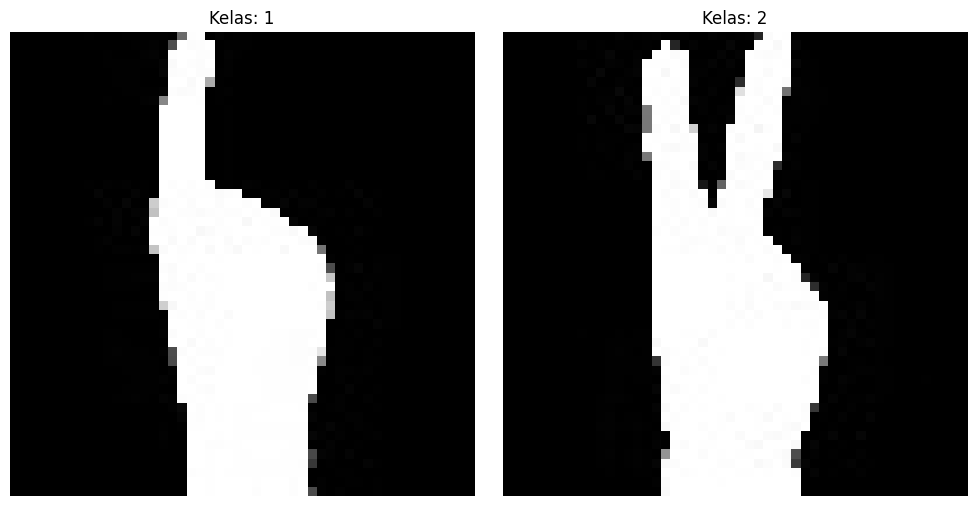

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

# Path dasar ke folder dataset
base_path = "D:/Semester 6/Komputer Vision/Project/visual-command/test"
folders = ["1", "2"]

# Buat figure untuk menampilkan gambar
plt.figure(figsize=(10, 5))

for i, selected_class in enumerate(folders):
    folder_path = os.path.join(base_path, selected_class)
    
    # Ambil semua nama file gambar di folder tersebut
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        # Ambil gambar pertama (atau bisa juga pilih secara acak)
        selected_image = image_files[0]
        image_path = os.path.join(folder_path, selected_image)
        
        # Baca dan konversi gambar
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Tampilkan di subplot
        plt.subplot(1, 2, i+1)
        plt.imshow(image_rgb)
        plt.title(f"Kelas: {selected_class}")
        plt.axis('off')
    else:
        print(f"Tidak ada gambar ditemukan di folder {folder_path}")

plt.tight_layout()
plt.show()


In [4]:
import cv2
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Path dasar ke folder dataset
base_path = "D:/Semester 6/Komputer Vision/Project/visual-command/test"
folders = ["1", "2"]

# Label mapping
label_map = {
    "1": 0,
    "2": 1
}

# Fungsi ekstraksi gabungan fitur piksel dan bentuk
def extract_combined_features(binary_img):
    # --- Fitur piksel ---
    edges = cv2.Canny(binary_img, 100, 200)
    total_edge_pixels = np.sum(edges > 0)

    white_pixel_count = np.sum(binary_img == 255)
    height = binary_img.shape[0]
    upper_half = binary_img[:height // 2, :]
    white_pixel_upper = np.sum(upper_half == 255)
    white_pixel_upper_ratio = white_pixel_upper / white_pixel_count if white_pixel_count > 0 else 0

    column_sum = np.sum(binary_img == 255, axis=0)
    peaks, _ = find_peaks(column_sum, distance=10, prominence=10)
    white_column_peaks = len(peaks)

    # --- Fitur bentuk ---
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        hull = cv2.convexHull(cnt, returnPoints=False)
        if hull is not None and len(hull) > 3:
            defects = cv2.convexityDefects(cnt, hull)
            num_defects = 0 if defects is None else defects.shape[0]
        else:
            num_defects = 0

        x, y, w, h = cv2.boundingRect(cnt)
        rect_area = w * h
        extent = float(cv2.contourArea(cnt)) / rect_area if rect_area > 0 else 0

        moments = cv2.moments(binary_img)
        hu_moments = cv2.HuMoments(moments).flatten()
        hu_moment_1 = -np.sign(hu_moments[0]) * np.log10(abs(hu_moments[0])) if hu_moments[0] != 0 else 0
    else:
        num_defects = 0
        extent = 0
        hu_moment_1 = 0

    return [
        total_edge_pixels,
        white_pixel_count,
        white_pixel_upper_ratio,
        white_column_peaks,
        num_defects,
        extent,
        hu_moment_1
    ]

# Proses ekstraksi fitur
data = []

for folder in folders:
    label_num = label_map[folder]
    folder_path = os.path.join(base_path, folder)

    if not os.path.exists(folder_path):
        print(f"Folder tidak ditemukan: {folder_path}")
        continue

    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for file in files:
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue

        # Konversi ke grayscale dan biner
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

        # Ekstraksi fitur
        features = extract_combined_features(binary_img)
        data.append([file, label_num] + features)

# Simpan ke CSV
columns = [
    "filename", "label",
    "total_edge_pixels", "white_pixel_count", "white_pixel_upper_ratio", "white_column_peaks",
    "num_defects", "extent", "hu_moment_1"
]
df = pd.DataFrame(data, columns=columns)

csv_output_path = "fitur_tangan_gabungan.csv"
df.to_csv(csv_output_path, index=False)
print(f"Fitur gabungan berhasil disimpan ke: {csv_output_path}")


Fitur gabungan berhasil disimpan ke: fitur_tangan_gabungan.csv


In [5]:
#pip install scikit-learn

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Baca CSV hasil ekstraksi fitur
df = pd.read_csv("fitur_tangan_gabungan.csv")

# Pisahkan kolom non-fitur (filename & label)
non_feature_cols = ['filename', 'label']
feature_cols = [col for col in df.columns if col not in non_feature_cols]

# Lakukan normalisasi dengan MinMaxScaler
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# Simpan ke file CSV baru
df_scaled.to_csv("fitur_tangan_normalized.csv", index=False)
print("Normalisasi selesai. Disimpan sebagai: fitur_tangan_normalized.csv")


Normalisasi selesai. Disimpan sebagai: fitur_tangan_normalized.csv


In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop(columns=["filename", "label"])
y = df["label"]

selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)

# Menampilkan fitur yang dipilih
selected_features = X.columns[selector.get_support()]
print("Fitur yang dipilih:", list(selected_features))


Fitur yang dipilih: ['total_edge_pixels', 'white_pixel_count', 'white_pixel_upper_ratio', 'extent', 'hu_moment_1']


In [8]:
#pip install seaborn

C:\Users\user\AppData\Local\Temp\ipykernel_2788\1989654809.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_limited = df_scaled.groupby('label', group_keys=False).apply(lambda x: x.sample(n=100, random_state=42) if len(x) > 100 else x)


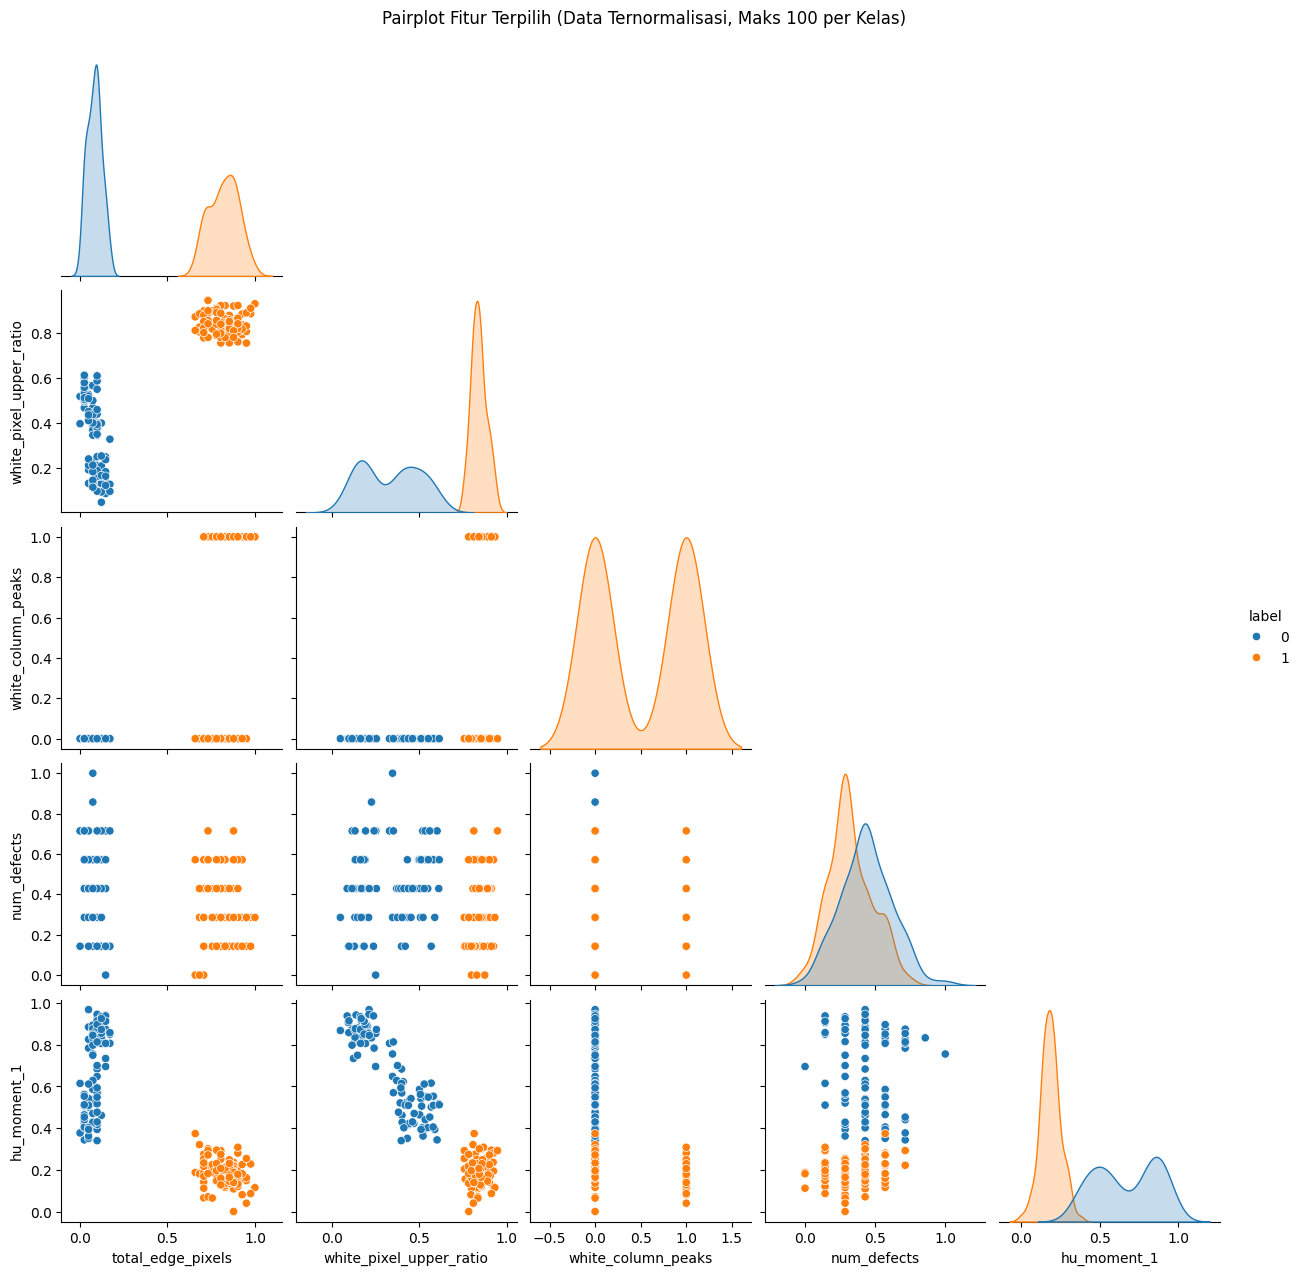

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pastikan label masih ada di df_scaled
df_scaled['label'] = df['label']  # Ambil label dari dataframe asli (sebelum scaling)

# Batasi jumlah data menjadi 100 per kelas
df_limited = df_scaled.groupby('label', group_keys=False).apply(lambda x: x.sample(n=100, random_state=42) if len(x) > 100 else x)

# Pilih fitur-fitur yang telah diseleksi
selected_features = ['total_edge_pixels', 'white_pixel_upper_ratio', 'white_column_peaks', 'num_defects', 'hu_moment_1']

# Buat pairplot
sns.pairplot(df_limited[selected_features + ['label']], hue='label', diag_kind='kde', corner=True)
plt.suptitle("Pairplot Fitur Terpilih (Data Ternormalisasi, Maks 100 per Kelas)", y=1.02)
plt.show()


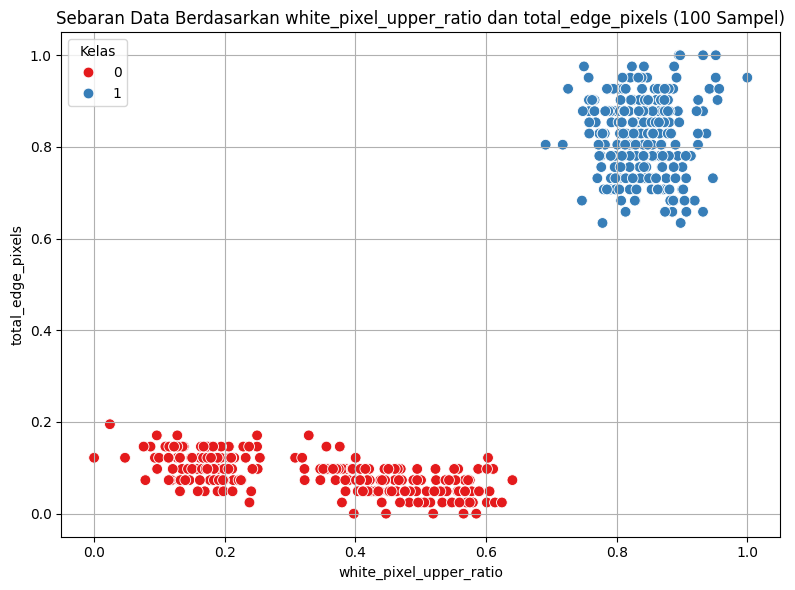

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sinkronkan label jika belum ada
df_scaled['label'] = df['label']

# Ambil 100 data secara acak dari keseluruhan dataset
df_sampled = df_scaled.sample(n=500, random_state=42)

# Pilih dua fitur yang akan divisualisasikan
# x_feature = 'total_edge_pixels'
x_feature = 'white_pixel_upper_ratio'
y_feature = 'total_edge_pixels'

# Buat scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sampled, x=x_feature, y=y_feature, hue='label', palette='Set1', s=60)

plt.title(f"Sebaran Data Berdasarkan {x_feature} dan {y_feature} (100 Sampel)")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend(title='Kelas', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


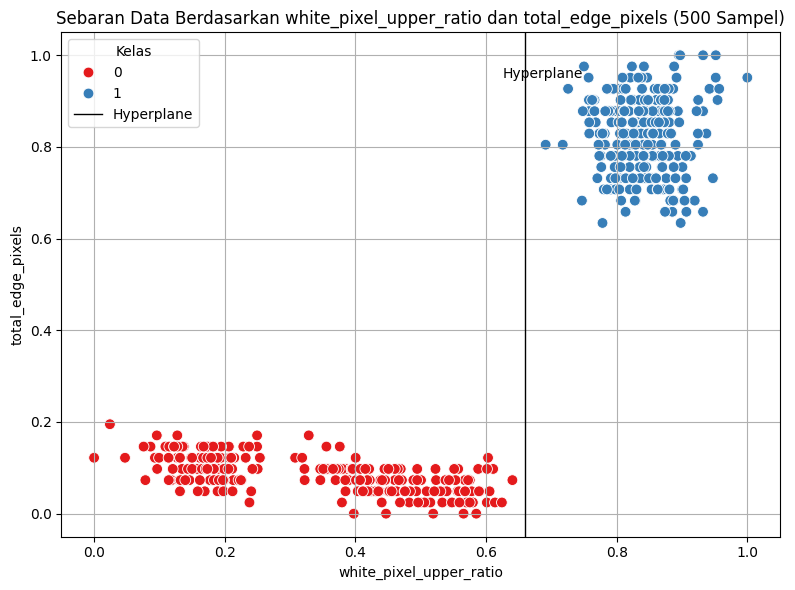

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sinkronkan label jika belum ada
df_scaled["label"] = df["label"]

# Ambil 100 data secara acak dari keseluruhan dataset
df_sampled = df_scaled.sample(n=500, random_state=42)

# Pilih dua fitur yang akan divisualisasikan
x_feature = "white_pixel_upper_ratio"
y_feature = "total_edge_pixels"

# Buat scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sampled, x=x_feature, y=y_feature, hue="label", palette="Set1", s=60
)

# Tambahkan garis vertikal (hyperplane)
plt.axvline(x=0.66, color="black", linestyle="-", linewidth=1, label="Hyperplane")
plt.text(
    0.625,
    df_sampled[y_feature].max() * 0.95,
    "Hyperplane",
    rotation=0,
    color="black",
    fontsize=10,
)

# Label dan layout
plt.title(f"Sebaran Data Berdasarkan {x_feature} dan {y_feature} (500 Sampel)")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.legend(title="Kelas", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

# 1. Pilih hanya dua fitur
X = df_scaled[['white_pixel_upper_ratio', 'total_edge_pixels']]
y = df_scaled['label'].replace(0, -1)  # Ubah 0 → -1

# 2. Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Tampilkan jumlah data
print(f"Jumlah data train: {X_train.shape}, test: {X_test.shape}\n")

# 4. Tampilkan sebaran kelas
print("Sebaran kelas pada data latih:")
print(y_train.value_counts().sort_index())

print("\nSebaran kelas pada data uji:")
print(y_test.value_counts().sort_index())

Jumlah data train: (480, 2), test: (120, 2)

Sebaran kelas pada data latih:
label
-1    240
 1    240
Name: count, dtype: int64

Sebaran kelas pada data uji:
label
-1    60
 1    60
Name: count, dtype: int64


In [14]:
print("Distribusi kelas y_train:", np.bincount(np.where(y_train == -1, 0, 1)))
print("Distribusi kelas y_test:", np.bincount(np.where(y_test == -1, 0, 1)))

Distribusi kelas y_train: [240 240]
Distribusi kelas y_test: [60 60]


Trying learning_rate=0.01, lambda_param=0.1

Distribusi prediksi akhir (training): {-1: 146, 1: 154}

Training selesai.
Bobot akhir: [0.95903678 0.14275414]
Bias akhir: 0.022096917541457754
F1 on validation: 0.8913

Trying learning_rate=0.01, lambda_param=0.01

Distribusi prediksi akhir (training): {-1: 146, 1: 154}

Training selesai.
Bobot akhir: [1.51482704 0.17063937]
Bias akhir: 0.05115296316418576
F1 on validation: 0.8791

Trying learning_rate=0.01, lambda_param=0.001

Distribusi prediksi akhir (training): {-1: 146, 1: 154}

Training selesai.
Bobot akhir: [1.8246302  0.17637375]
Bias akhir: 0.08189457070186024
F1 on validation: 0.8791

Trying learning_rate=0.005, lambda_param=0.1

Distribusi prediksi akhir (training): {-1: 146, 1: 154}

Training selesai.
Bobot akhir: [0.92264933 0.16051419]
Bias akhir: 0.01454743552072181
F1 on validation: 0.8913

Trying learning_rate=0.005, lambda_param=0.01

Distribusi prediksi akhir (training): {-1: 145, 1: 155}

Training selesai.
Bobot akhir: 

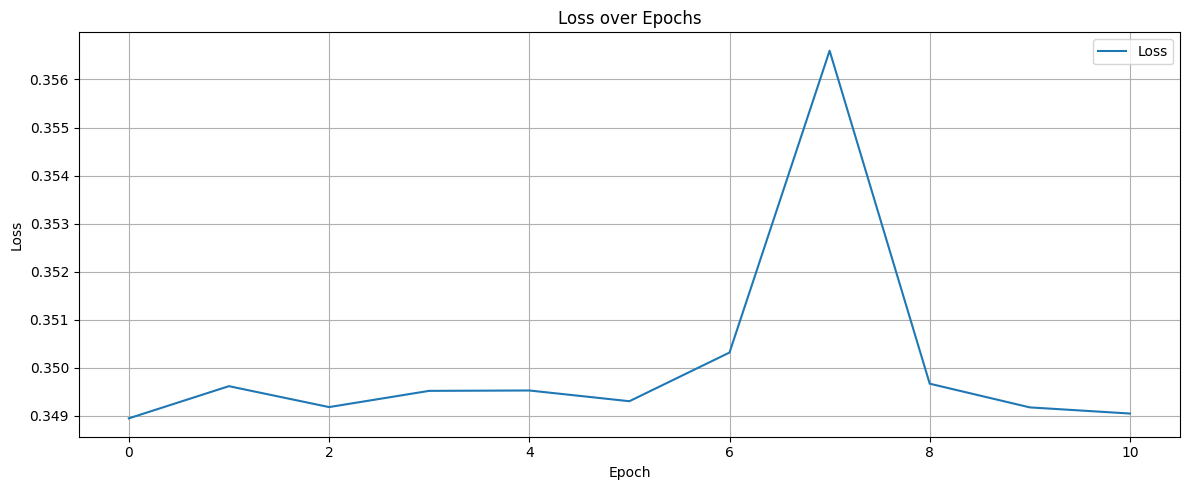

✅ Model berhasil disimpan ke svm_model.pkl


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=500, verbose=True):
        self.initial_lr = learning_rate
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.verbose = verbose
        self.w = None
        self.b = None
        self.losses = []
        self.train_acc = []
        self.val_acc = []

    def save_model(self, filepath):
        """Simpan bobot dan bias ke file"""
        with open(filepath, 'wb') as f:
            pickle.dump({'w': self.w, 'b': self.b}, f)
        if self.verbose:
            print(f"✅ Model berhasil disimpan ke {filepath}")

    def load_model(self, filepath):
        """Muat bobot dan bias dari file"""
        with open(filepath, 'rb') as f:
            params = pickle.load(f)
            self.w = params['w']
            self.b = params['b']
        if self.verbose:
            print(f"✅ Model berhasil dimuat dari {filepath}")

    def predict(self, X, threshold=0.0):
        linear_output = np.dot(X, self.w) + self.b
        return np.where(linear_output >= threshold, 1, -1)

    def evaluate_metrics(self, X, y_true):
        y_pred = self.predict(X)
        y_true_bin = np.where(y_true == -1, 0, 1)
        y_pred_bin = np.where(y_pred == -1, 0, 1)

        accuracy = accuracy_score(y_true_bin, y_pred_bin)
        precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
        f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

        if self.verbose:
            print(f"\n--- Evaluation Metrics ---")
            print(f"Accuracy : {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall   : {recall:.4f}")
            print(f"F1-score : {f1:.4f}")
            print(f"Predicted class distribution: {np.unique(y_pred, return_counts=True)}")

        return accuracy, precision, recall, f1

    def fit(self, X, y, X_val=None, y_val=None, early_stop_rounds=10, max_attempts=5):
        n_samples, n_features = X.shape
        best_loss = float('inf')
        rng = np.random.default_rng(42)

        for attempt in range(max_attempts):
            self.w = rng.normal(scale=0.01, size=n_features)
            self.b = 0
            self.losses = []
            self.train_acc = []
            self.val_acc = []
            self.lr = self.initial_lr
            no_improve_epochs = 0

            for epoch in range(self.n_iters):
                indices = np.arange(n_samples)
                np.random.shuffle(indices)
                X_shuffled = X[indices]
                y_shuffled = y[indices]

                for idx, x_i in enumerate(X_shuffled):
                    condition = y_shuffled[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                    if condition:
                        grad_w = 2 * self.lambda_param * self.w
                        grad_b = 0
                    else:
                        grad_w = 2 * self.lambda_param * self.w - y_shuffled[idx] * x_i
                        grad_b = -y_shuffled[idx]

                    self.w -= self.lr * grad_w
                    self.b -= self.lr * grad_b

                distances = 1 - y * (np.dot(X, self.w) + self.b)
                hinge_loss = np.maximum(0, distances)
                loss = np.mean(hinge_loss) + self.lambda_param * np.dot(self.w, self.w)
                self.losses.append(loss)

                y_train_pred = self.predict(X)
                train_acc = np.mean(y_train_pred == y)
                self.train_acc.append(train_acc)

                if X_val is not None and y_val is not None:
                    val_pred = self.predict(X_val)
                    val_accuracy = np.mean(val_pred == y_val)
                    self.val_acc.append(val_accuracy)

                    if self.verbose:
                        print(f"Epoch {epoch+1}/{self.n_iters} - Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_accuracy:.4f}")
                else:
                    if self.verbose:
                        print(f"Epoch {epoch+1}/{self.n_iters} - Loss: {loss:.4f}, Train Acc: {train_acc:.4f}")

                if loss < best_loss - 1e-4:
                    best_loss = loss
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

                if no_improve_epochs >= early_stop_rounds:
                    if self.verbose:
                        print(f"Early stopping at epoch {epoch+1}")
                    break

                self.lr = self.initial_lr * (0.99 ** epoch)

            final_preds = self.predict(X)
            unique = np.unique(final_preds)

            print(f"\nDistribusi prediksi akhir (training): {dict(zip(*np.unique(final_preds, return_counts=True)))}")
            if -1 not in unique or 1 not in unique:
                print("⚠️  Model gagal memisahkan kedua kelas, mencoba ulang...\n")
                continue
            else:
                break

        print("\nTraining selesai.")
        print(f"Bobot akhir: {self.w}")
        print(f"Bias akhir: {self.b}")

    def plot_loss(self):
        plt.figure(figsize=(12, 5))
        plt.plot(self.losses, label='Loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


def tune_hyperparameters(X_train, y_train, X_val, y_val):
    best_params = None
    best_f1 = -np.inf

    learning_rates = [0.01, 0.005]
    lambda_params = [0.1, 0.01, 0.001]

    for lr in learning_rates:
        for lmbd in lambda_params:
            print(f"Trying learning_rate={lr}, lambda_param={lmbd}")
            model = SVM(learning_rate=lr, lambda_param=lmbd, n_iters=300, verbose=False)
            model.fit(X_train, y_train, X_val, y_val)
            _, _, _, f1 = model.evaluate_metrics(X_val, y_val)
            print(f"F1 on validation: {f1:.4f}\n")

            if f1 > best_f1:
                best_f1 = f1
                best_params = (lr, lmbd)

    print(f"Best params: learning_rate={best_params[0]}, lambda_param={best_params[1]}, F1={best_f1:.4f}")
    return best_params


# ==== MAIN ====
if __name__ == "__main__":
    from sklearn.datasets import make_classification

    # Buat dataset dummy
    X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                               n_redundant=0, class_sep=1.2, random_state=42)
    y = np.where(y == 0, -1, 1)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Tuning hyperparameter
    best_lr, best_lmbd = tune_hyperparameters(X_train, y_train, X_val, y_val)

    # Final training
    final_model = SVM(learning_rate=best_lr, lambda_param=best_lmbd, n_iters=500, verbose=True)
    final_model.fit(X_train, y_train, X_val, y_val)

    # Evaluasi akhir
    final_model.evaluate_metrics(X_test, y_test)
    final_model.plot_loss()

    # Simpan model ke file
    final_model.save_model("svm_model.pkl")



--- Evaluation Metrics ---
Accuracy : 0.9500
Precision: 0.9138
Recall   : 1.0000
F1-score : 0.9550
Predicted class distribution: (array([-1,  1]), array([42, 58], dtype=int64))

Confusion Matrix:
[[53  0]
 [ 5 42]]


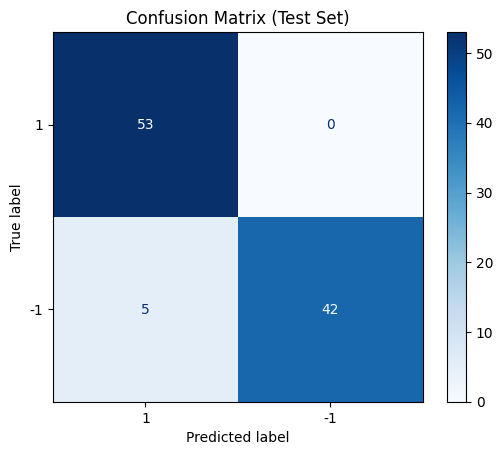


Akurasi akhir pada data uji: 0.9500


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluasi akhir
acc, prec, rec, f1 = final_model.evaluate_metrics(X_test, y_test)

# Confusion matrix
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])

print("\nConfusion Matrix:")
print(cm)

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, -1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

# Tambahan info
print(f"\nAkurasi akhir pada data uji: {acc:.4f}")


In [17]:
from sklearn.model_selection import train_test_split

# 1. Pilih hanya dua fitur
X = df_scaled[['white_pixel_upper_ratio', 'total_edge_pixels']]
y = df_scaled['label'].replace(0, -1)  # Ubah 0 → -1

# 2. Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Tampilkan jumlah data
print(f"Jumlah data train: {X_train.shape}, test: {X_test.shape}\n")

# 4. Tampilkan sebaran kelas
print("Sebaran kelas pada data latih:")
print(y_train.value_counts().sort_index())

print("\nSebaran kelas pada data uji:")
print(y_test.value_counts().sort_index())



Jumlah data train: (480, 2), test: (120, 2)

Sebaran kelas pada data latih:
label
-1    240
 1    240
Name: count, dtype: int64

Sebaran kelas pada data uji:
label
-1    60
 1    60
Name: count, dtype: int64


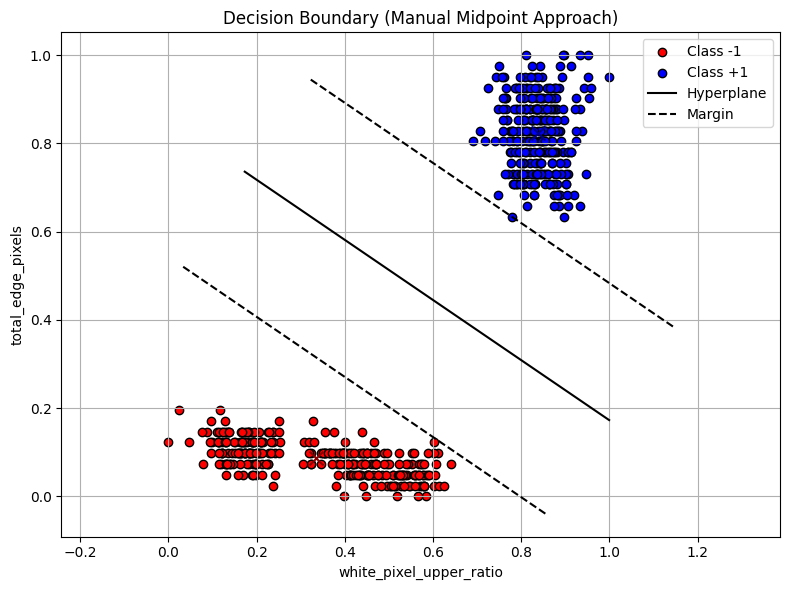

Margin (jarak ke support vector terdekat): 0.2568


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_manual_decision_boundary(df_scaled, title="Decision Boundary (Manual Midpoint Approach)"):
    x_feature = 'white_pixel_upper_ratio'
    y_feature = 'total_edge_pixels'

    # Ekstrak data
    X = df_scaled[[x_feature, y_feature]].values
    y = df_scaled['label'].replace(0, -1).values
    X_neg = X[y == -1]
    X_pos = X[y == 1]

    # Hitung centroid
    centroid_neg = X_neg.mean(axis=0)
    centroid_pos = X_pos.mean(axis=0)

    # Bobot sebagai vektor dari centroid - ke +
    w = centroid_pos - centroid_neg
    w_norm = np.linalg.norm(w)
    w_unit = w / w_norm

    # Titik tengah antara centroid
    midpoint = (centroid_pos + centroid_neg) / 2

    # Bias agar midpoint berada di hyperplane
    b = -np.dot(w, midpoint)

    # Hitung margin secara geometris
    dist_neg = np.abs(np.dot(X_neg, w) + b) / w_norm
    dist_pos = np.abs(np.dot(X_pos, w) + b) / w_norm
    margin = min(dist_neg.min(), dist_pos.min())

    # Buat garis hyperplane: tegak lurus w, melalui midpoint
    ortho_direction = np.array([-w_unit[1], w_unit[0]])
    t = np.linspace(-0.5, 0.5, 500)  # DIPERSEMPIT agar garis lebih pendek
    line_x = midpoint[0] + t * ortho_direction[0]
    line_y = midpoint[1] + t * ortho_direction[1]

    # Garis margin (di-offset sejauh margin)
    offset_vec = margin * w_unit
    upper_point = midpoint + offset_vec
    lower_point = midpoint - offset_vec
    margin_line_x1 = upper_point[0] + t * ortho_direction[0]
    margin_line_y1 = upper_point[1] + t * ortho_direction[1]
    margin_line_x2 = lower_point[0] + t * ortho_direction[0]
    margin_line_y2 = lower_point[1] + t * ortho_direction[1]

    # Plot semua
    plt.figure(figsize=(8, 6))
    plt.scatter(X_neg[:, 0], X_neg[:, 1], color='red', edgecolors='k', label='Class -1')
    plt.scatter(X_pos[:, 0], X_pos[:, 1], color='blue', edgecolors='k', label='Class +1')
    plt.plot(line_x, line_y, 'k-', label='Hyperplane')
    plt.plot(margin_line_x1, margin_line_y1, 'k--', label='Margin')
    plt.plot(margin_line_x2, margin_line_y2, 'k--')

    plt.scatter(*centroid_neg, color='darkred', marker='x', s=100)
    plt.scatter(*centroid_pos, color='darkblue', marker='x', s=100)

    # Rentang sumbu (zoom in)
    plt.xlim(0.0, 1.2)
    plt.ylim(-0.1, 1.2)

    # Label dan dekorasi
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # Cetak margin
    print(f"Margin (jarak ke support vector terdekat): {margin:.4f}")


# Jalankan
plot_manual_decision_boundary(df_scaled)



